In [6]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

# Data Test 0

In [8]:
import numpy as np
from numpy import pi
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data0Path = r'../dataset/data0test.txt'
data0Label = r'../dataset/data0testlabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

In [43]:
np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(4):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

69.92426300048828
57.71657943725586
60.844970703125
53.28907775878906
53.207862854003906
53.19691467285156
53.196510314941406
53.196502685546875


Accuracy: 0.9


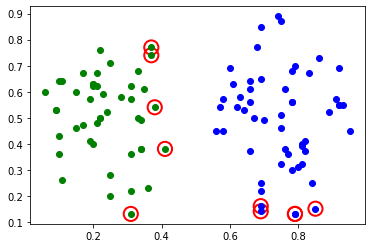

In [44]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

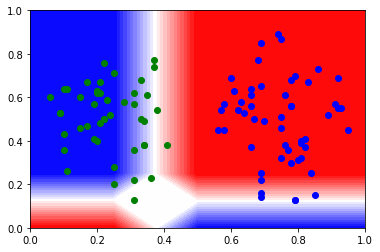

In [45]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 1a

In [46]:
data1aPath = r'../dataset/data1a.txt'
data1aLabel = r'../dataset/data1alabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(4):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);


69.69514465332031
60.131038665771484
63.71514129638672
56.87223815917969
56.80488967895508
56.792606353759766
56.79178237915039
56.79176712036133
56.79176330566406


Accuracy: 0.8


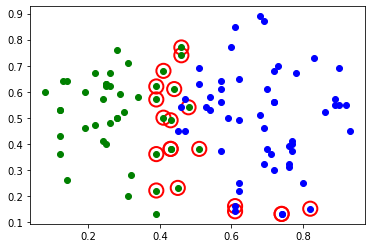

In [47]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

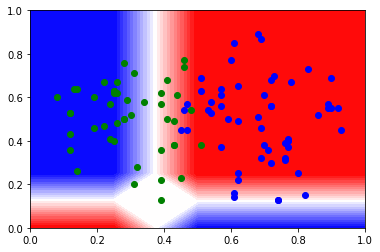

In [48]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 1b

In [4]:
import torch
torch.cuda.is_available()

True

In [11]:
data1bPath = r'../dataset/data1b.txt'
data1bLabel = r'../dataset/data1blabel.txt'

dataCoords = np.loadtxt(data1bPath)
dataLabels = np.loadtxt(data1bLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(4):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);


69.85095977783203
64.14896392822266
65.56118774414062
75.8653793334961
74.83566284179688
73.8965072631836
73.05293273925781
69.60700988769531
69.62567138671875
68.64056396484375
78.3388671875
61.68692398071289
76.00666046142578
60.22193145751953
65.06405639648438
59.91168212890625
59.85764694213867
59.845951080322266
59.84560775756836
59.845611572265625


Accuracy: 0.71


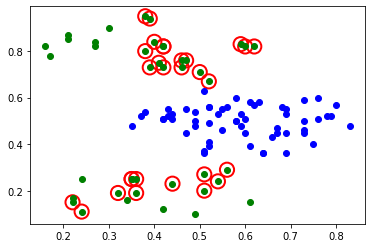

In [13]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

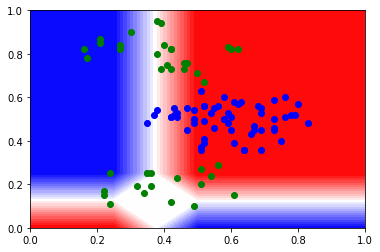

In [14]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 1c

In [15]:
data1aPath = r'../dataset/data1c.txt'
data1aLabel = r'../dataset/data1clabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(4):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);


70.63034057617188
63.27632522583008
58.244911193847656
57.15947723388672
55.83489227294922
55.761112213134766
55.75981903076172
55.75981903076172


Accuracy: 0.81


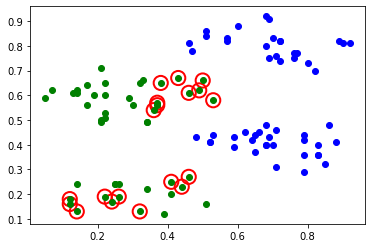

In [16]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

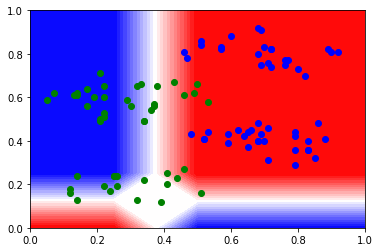

In [17]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 2a

In [18]:
data1aPath = r'../dataset/data2a.txt'
data1aLabel = r'../dataset/data2alabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(4):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);


57.9971809387207
53.31096267700195
53.27298355102539
53.27156448364258
53.271575927734375
53.27156448364258


Accuracy: 0.93


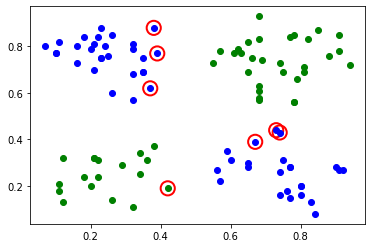

In [19]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

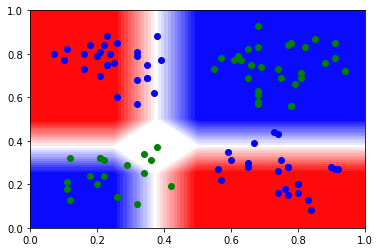

In [20]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 2b

In [21]:
data1aPath = r'../dataset/data2b.txt'
data1aLabel = r'../dataset/data2blabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(4):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);


70.54167175292969
68.63892364501953
68.32179260253906
68.02513122558594
68.01366424560547
68.01223754882812
68.01222229003906


Accuracy: 0.54


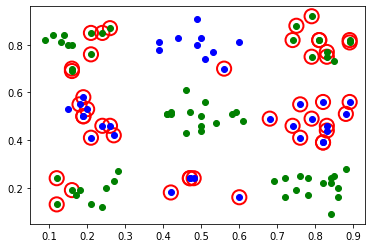

In [22]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

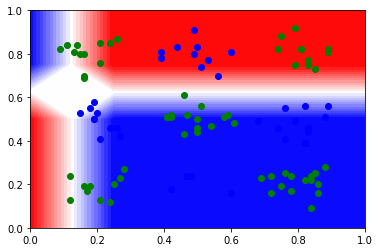

In [23]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 2c

In [24]:
data1aPath = r'../dataset/data2c.txt'
data1aLabel = r'../dataset/data2clabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(4):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);


70.0572509765625
68.9258804321289
68.7099380493164
68.68232727050781
68.66046905517578
68.65864562988281
68.65855407714844
68.65856170654297


Accuracy: 0.57


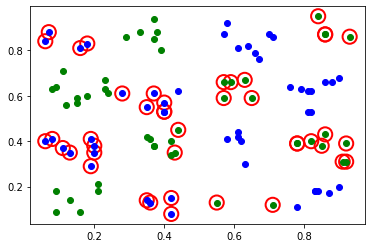

In [25]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

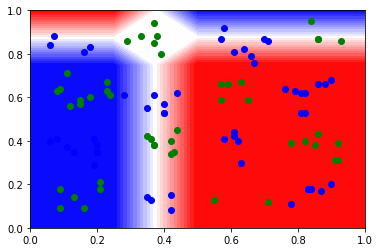

In [26]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 3a

In [27]:
data1aPath = r'../dataset/data3a.txt'
data1aLabel = r'../dataset/data3alabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(4):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);


70.70464324951172
70.61651611328125
69.44303131103516
71.58728790283203
73.8666000366211
74.33988189697266
70.84915924072266
72.231689453125
76.48797607421875
62.156463623046875
80.25787353515625
75.80397033691406
68.79683685302734
69.8816146850586
79.83380126953125
73.55801391601562
70.20198059082031
67.89959716796875
76.16451263427734
73.6123046875


Accuracy: 0.39


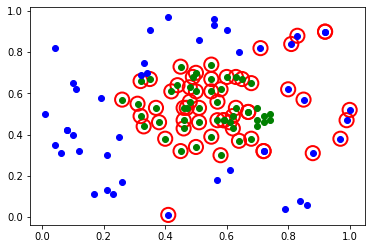

In [28]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

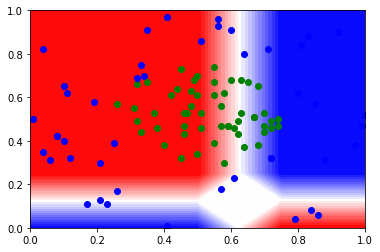

In [29]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 3b

In [30]:
data1aPath = r'../dataset/data3b.txt'
data1aLabel = r'../dataset/data3blabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(4):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);


63.67048645019531
62.7578239440918
62.622230529785156
62.62193298339844
62.6219367980957
62.621925354003906


Accuracy: 0.78


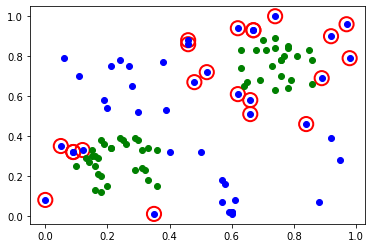

In [31]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

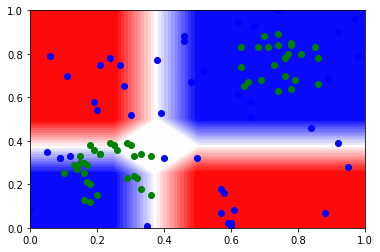

In [32]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 3c

In [33]:
data1aPath = r'../dataset/data3c.txt'
data1aLabel = r'../dataset/data3clabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(4):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);


69.63619232177734
68.18974304199219
68.07624053955078
68.00316619873047
67.99467468261719
67.99375915527344
67.99374389648438
67.99375915527344


Accuracy: 0.49


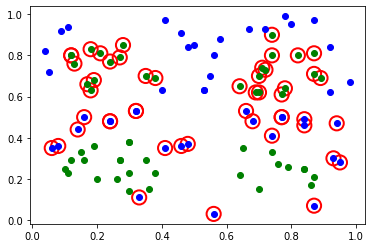

In [34]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

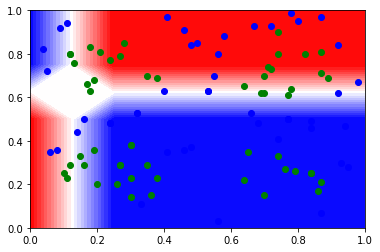

In [35]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)